In [510]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform, pdist
from scipy.cluster import hierarchy
from matplotlib import pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from typing import List, Union, Tuple
from numpy.typing import ArrayLike

In [4]:
df = pd.DataFrame({
    'age': [44, 18, 40, 33, 33, 50, 22, 23, 39, 42, 57, 51],
    'gender': pd.Categorical(['f', 'm', 'f', 'f', 'm', 'f', 'f', 'f', 'm', 'm', 'm', 'm']),
    'ethnicity': pd.Categorical(['A', 'B', 'A', 'D', 'C', 'B', 'A', 'A', 'B', 'B', 'C', 'C'])
})

In [16]:
def create_numerical_df(df:pd.DataFrame, dummy_columns:list)->pd.DataFrame:
    """Creates an encoded dataframe for the use in the ASW clustering method.

    Args:
        df (pd.DataFrame): data you want to cluster
        dummy_columns (list): columns you want encoded. All other columns will remain the same

    Returns:
        pd.DataFrame: the data frame with encodings for specified columns
    """

    subset_df = df[dummy_columns]
    keep_df = df.drop(columns=dummy_columns)
    dummy_df = pd.get_dummies(subset_df,dtype=float)*1/(2**(1/2))
    
    return pd.concat([keep_df,dummy_df],axis=1)


In [496]:
def h_clustering(data:pd.DataFrame,n_cluster:int, method:str = 'ward')->ArrayLike:
    """Conduct hierarchical clustering based on provided arguments

    Args:
        data (pd.DataFrame): data to be clustered
        n_cluster (int): number of clusters
        method (str, optional): Method to use. Defaults to 'ward'.

    Returns:
        ArrayLike: initial cluster assignments
    """
    
    linkage = hierarchy.linkage(data, method = method)
    cluster_assignments = hierarchy.cut_tree(linkage, n_clusters=n_cluster)

    return cluster_assignments.T[0]
    

In [288]:
def dist_matrix_e(data:Union[ArrayLike,pd.DataFrame], weights:ArrayLike=None)->ArrayLike:
    """Calculate n x n Euclidean distance matrix, containing the pairwise Euclidean
    distances between the n group members

    Args:
        data (Union[ArrayLike,pd.DataFrame]): dummy encoded data
        weights (ArrayLike, optional): Weights for features. Defaults to None.

    Returns:
        ArrayLike: n x n Euclidean distance matrix
    """
    # Check if the input is a DataFrame; if so, convert to a NumPy array
    if isinstance(data, pd.DataFrame):
        data = data.values
        
    # If weights are not provided, set them to 1 for all columns
    if weights is None:
        weights = np.ones(data.shape[1])
    else:
        # Ensure weights are a NumPy array for consistency
        weights = np.asarray(weights)

    # Apply weights to data
    weighted_data = data * weights

    # Calculate pairwise distances using pdist and convert to a square matrix
    # The 'euclidean' metric is used because we're calculating the Euclidean distance
    dist_matrix = squareform(pdist(weighted_data, metric='euclidean'))

    return dist_matrix

In [470]:
def calculate_asw(dist_matrix:ArrayLike,assignments:ArrayLike)->float:
    """Calculates the average silhouette width for cluster assignments

    Args:
        dist_matrix (ArrayLike): distance matrix, n x n
        assignments (ArrayLike): cluster assignments 1 x n

    Returns:
        float: the average silhouette width for current assignments
    """
    a_i = np.zeros(len(assignments))
    b_i = np.zeros(len(assignments))
    classes = np.unique(assignments)
    num_classes = len(classes)

    isolates = []

    for idx, c_l in enumerate(assignments):
        
        all_b_i = np.zeros(num_classes)

        # Find neighbors in their assigned cluster
        g = np.where(assignments == c_l)[0]
        neighbors = g[g!=idx]

        # if they are an isolate, their sil width becomes 0
        if len(neighbors) == 0:
            isolates.append(idx)
            a_distances = [0]
        # get distances for neighbors
        else:
            a_distances = dist_matrix[idx][neighbors]

        # get distances for members of other clusters
        for c in classes:
            if c!=c_l:
                
                g = np.where(assignments == c)[0]

                b_distances = dist_matrix[idx][g]

                index = np.where(classes==c)[0][0]
                all_b_i[index] = np.mean(b_distances)

        # remove the 0 for the assigned group
        c_l_index = np.where(classes==c_l)[0][0]
        all_b_i = np.delete(all_b_i,c_l_index)

        a_i[idx] = np.mean(a_distances)
        b_i[idx] = np.min(all_b_i)

    sil_width = (b_i-a_i)/np.maximum(a_i,b_i)

    # if a person is by themselves, their sil width becomes 0
    if len(isolates)>0:
        for i in isolates:
            sil_width[i] = 0

    asw = np.mean(sil_width)

    return asw

In [512]:
def reassign_members(dist_matrix:ArrayLike, assignments:ArrayLike)->Tuple[dict,float,ArrayLike]:
    """Iterates through each member and then assigns them to different
    clusters. For each iteration every member is assigned to the other cluster.
    The optimal move is the maximum ASW calculated starting with the initial assignments.

    Args:
        dist_matrix (ArrayLike): distances
        assignments (ArrayLike): cluster assignments

    Returns:
        Tuple(dict,float,ArrayLike): dictionary of optimal change id: group, maximum ASW, optimal cluster assignments
    """

    classes = np.unique(assignments)
    update_move = {}
    optimal_assignment = assignments.copy()
    max_asw = calculate_asw(dist_matrix,assignments)

    for idx, c_l in enumerate(assignments):

        for new_class in classes:
            if c_l != new_class:
                temp_assignment = assignments.copy()
                temp_assignment[idx] = new_class

                new_asw = calculate_asw(dist_matrix,temp_assignment)

                if new_asw > max_asw:
                    update_move = {idx:new_class}
                    optimal_assignment = temp_assignment.copy()
                    max_asw = new_asw

    return update_move, max_asw, optimal_assignment

In [521]:
def _fit(data,n_clusters):

    if n_clusters>data.shape[0]:
        raise ValueError("The number of clusters {} exceeds the number of observations {}".format(n_clusters,data.shape[0]))
    
    dist_matrix = dist_matrix_e(data)

    best_fit = {'optimal_assignment': [],
                'asw':-99,
                'method':'',
                'number_of_groups': 0}

    for n in range(2,n_clusters+1):

        initial_assignments = h_clustering(data,n,'ward')

        update_move, temp_max_asw, optimal_assignments = reassign_members(dist_matrix, initial_assignments)
        
        if temp_max_asw > best_fit['asw']:
            best_fit['optimal_assignment'] = optimal_assignments
            best_fit['asw'] = temp_max_asw
            best_fit['method'] = 'ward'
            best_fit['number_of_groups'] = n

    for n in range(2,n_clusters+1):

        initial_assignments = h_clustering(data,n,'average')

        update_move, temp_max_asw, optimal_assignments = reassign_members(dist_matrix, initial_assignments)

        if temp_max_asw > best_fit['asw']:
            best_fit['optimal_assignment'] = optimal_assignments
            best_fit['asw'] = temp_max_asw
            best_fit['method'] = 'average'
            best_fit['number_of_groups'] = n
        elif temp_max_asw == best_fit['asw'] and best_fit['method'] == 'ward':
            best_fit['method'] = ['ward', 'average']
        
    return best_fit

In [522]:
_fit(dummy_df,6)

{'optimal_assignment': array([0, 1, 0, 2, 2, 3, 1, 1, 0, 0, 3, 3]),
 'asw': np.float64(0.6527976437863343),
 'method': ['ward', 'average'],
 'number_of_groups': 4}

In [ ]:
1 2 1 3 3 4 2 2 1 1 4 4

In [501]:
_fit(dummy_df,15)

ValueError: The number of clusters 15 exceeds the number of observations 12

In [491]:
ward_assignments

array([[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]])

In [ ]:
1 2 3 4 4 5 2 2 3 1 6 5

In [ ]:
np.array([1, 2, 1, 3, 3, 4, 2, 2, 1, 1, 5, 4])
np.array([1, 2, 3, 4, 4, 5, 2, 2, 3, 1, 6, 5])

In [495]:
reassign_members(dist_matrix, np.array([1, 2, 3, 4, 4, 5, 2, 2, 3, 1, 6, 5]))

0.5657873029390955
0.5657873029390955
0.5657873029390955
0.5657873029390955
0.5657873029390955
0.5657873029390955
0.5657873029390955
0.5657873029390955
0.5657873029390955
0.5657873029390955
0.5657873029390955
0.5657873029390955


({},
 np.float64(0.5657873029390955),
 array([1, 2, 3, 4, 4, 5, 2, 2, 3, 1, 6, 5]))

In [508]:
print(calculate_asw(dist_matrix, np.array([1, 2, 1, 1, 1, 3, 2, 2, 1, 1, 3, 3])))
print(calculate_asw(dist_matrix, np.array([1, 2, 1, 3, 3, 4, 2, 2, 1, 1, 4, 4])))
calculate_asw(dist_matrix, np.array([1, 2, 3, 4, 4, 5, 2, 2, 3, 1, 6, 5]))

0.6066793488028118
0.6527976437863343


np.float64(0.5657873029390955)

In [18]:
dummy_df = create_numerical_df(df, ['gender','ethnicity'])

In [478]:
ward_assignments = h_clustering(dummy_df,2,'ward')

In [289]:
dist_matrix = dist_matrix_e(dummy_df)

In [292]:
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,26.038433,4.000000,11.045361,11.090537,6.082763,22.000000,21.000000,5.196152,2.449490,13.076697,7.141428
1,26.038433,0.000000,22.045408,15.066519,15.033296,32.015621,4.242641,5.196152,21.000000,24.000000,39.012818,33.015148
2,4.000000,22.045408,0.000000,7.071068,7.141428,10.049876,18.000000,17.000000,1.732051,2.449490,17.058722,11.090537
3,11.045361,15.066519,7.071068,0.000000,1.414214,17.029386,11.045361,10.049876,6.164414,9.110434,24.041631,18.055470
4,11.090537,15.033296,7.141428,1.414214,0.000000,17.058722,11.090537,10.099505,6.082763,9.055385,24.000000,18.000000
5,6.082763,32.015621,10.049876,17.029386,17.058722,0.000000,28.017851,27.018512,11.045361,8.062258,7.141428,1.732051
6,22.000000,4.242641,18.000000,11.045361,11.090537,28.017851,0.000000,1.000000,17.058722,20.049938,35.028560,29.034462
7,21.000000,5.196152,17.000000,10.049876,10.099505,27.018512,1.000000,0.000000,16.062378,19.052559,34.029399,28.035692
8,5.196152,21.000000,1.732051,6.164414,6.082763,11.045361,17.058722,16.062378,0.000000,3.000000,18.027756,12.041595
9,2.449490,24.000000,2.449490,9.110434,9.055385,8.062258,20.049938,19.052559,3.000000,0.000000,15.033296,9.055385


In [ ]:
[np.float64(26.038433132583073), np.float64(22.0), np.float64(21.0)]

In [370]:
np.mean([dist_matrix[1][0],dist_matrix[1][2],dist_matrix[1][3],dist_matrix[1][4],dist_matrix[1][5],dist_matrix[1][8],dist_matrix[1][9],dist_matrix[1][10],dist_matrix[1][11]])

np.float64(25.247471555687653)

In [367]:
dist_matrix[1][2]

np.float64(22.045407685048602)

In [ ]:
[np.float64(26.038433132583073), np.float64(22.0), np.float64(21.0), np.float64(26.038433132583073), np.float64(22.045407685048602), np.float64(15.066519173319364), np.float64(15.033296378372908), np.float64(32.01562118716424), np.float64(21.0), np.float64(24.0), np.float64(39.01281840626232), np.float64(33.015148038438355)]

In [364]:
ward_assignments

array([[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]])

In [307]:
cluster_labels = np.unique(ward_assignments)

In [296]:
dist_matrix[0]

array([ 0.        , 26.03843313,  4.        , 11.04536102, 11.09053651,
        6.08276253, 22.        , 21.        ,  5.19615242,  2.44948974,
       13.07669683,  7.14142843])

In [308]:
ward_assignments

array([[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]])

In [314]:
np.zeros(2)

array([0., 0.])

In [404]:
np.unique(ward_assignments[0])

array([0, 1])

In [407]:
g = np.where(ward_assignments[0] == 0)[0]
g[g!=0]

array([ 2,  3,  4,  5,  8,  9, 10, 11])

In [408]:
ward_assignments[0]

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [416]:
all_b_i

array([0., 0.])

In [424]:
np.where(classes==1)

(array([1]),)

In [437]:
a_i = np.zeros(len(ward_assignments[0]))
b_i = np.zeros(len(ward_assignments[0]))
classes = np.unique(ward_assignments[0])
num_classes = len(classes)

for idx, c_l in enumerate(ward_assignments[0]):
    
    all_b_i = np.zeros(num_classes)

    a_distances = []
    # Find neighbors in their assigned cluster
    g = np.where(ward_assignments[0] == c_l)[0]
    neighbors = g[g!=idx]

    # append their distances
    for i in neighbors:
        a_distances.append(dist_matrix[idx][i])

    for c in classes:
        if c!=c_l:
            b_distances = []
            g = np.where(ward_assignments[0] == c)[0]

            for i in g:
                b_distances.append(dist_matrix[idx][i])

            index = np.where(classes==c)[0][0]
            all_b_i[index] = np.mean(b_distances)

    # remove the 0 for the assigned group
    c_l_index = np.where(classes==c_l)[0][0]
    all_b_i = np.delete(all_b_i,c_l_index)

    a_i[idx] = np.mean(a_distances)
    b_i[idx] = np.min(all_b_i)
    # print(b_distances)
    
sil_width = (b_i-a_i)/np.maximum(a_i,b_i)

asw = np.mean(sil_width)

In [438]:
asw

np.float64(0.5806374287702937)

In [435]:
c_l_index = np.where(classes==c_l)[0][0]
all_b_i = np.delete(all_b_i,c_l_index)

In [436]:
all_b_i

array([30.02843395])

In [434]:
c_l_index

np.int64(0)

In [ ]:
all_b_i

In [413]:
a_i

array([ 7.51030343,  4.71939655,  7.57414638, 11.74149712, 11.73038103,
        9.77523058,  2.62132034,  3.09807621,  7.91126147,  7.27696718,
       15.54744134, 10.38955819])

In [414]:
asw

np.float64(0.5806374287702937)

In [375]:
asw

np.float64(0.5806374287702937)

In [373]:
dist_matrix[1][2]

np.float64(22.045407685048602)

In [349]:
silhouette_width(dist_matrix,ward_assignments[0])

array([0.67364685, 0.81307449, 0.60167803, 0.02591867, 0.0284953 ,
       0.66312438, 0.87669238, 0.84709074, 0.56146892, 0.6540406 ,
       0.56840947, 0.65400932])

In [361]:
a_i,b_i

(array([7.51030343, 6.95212206, 7.22857731, 8.61716802, 9.34968873,
        9.43074432, 9.12122505, 8.85934901, 8.7188916 , 8.53283684,
        9.33450592, 9.44271641]),
 array([23.01281104, 24.68880643, 23.55407232, 21.63738004, 20.27124659,
        21.3645068 , 21.33556346, 21.10527416, 20.900947  , 20.90927316,
        21.79835076, 22.25557761]))

In [ ]:
iteration 0 7.510303434818697 23.012811044194354
iteration 1 4.719396554912958 25.247471555687653
iteration 2 7.574146378440334 19.0151358950162
iteration 3 11.74149712313449 12.053918603875838
iteration 4 11.730381034374123 12.074445941048134
iteration 5 9.775230578521878 29.017328270540215
iteration 6 2.6213203435596424 21.25838119989176
iteration 7 3.098076211353316 20.260880067917967
iteration 8 7.911261467105277 18.040366837813664
iteration 9 7.276967183457119 21.034165513007025
iteration 10 15.547441335554039 36.02359241229447
iteration 11 10.38955819308983 30.028433952702226

In [393]:
np.array([1, 2, 1, 1, 1, 3, 2, 2, 1, 1, 3, 3])

array([1, 2, 1, 1, 1, 3, 2, 2, 1, 1, 3, 3])

In [392]:
ward_assignments[0]

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [455]:
groups = np.array([1, 2, 3, 4, 4, 5, 2, 2, 3, 1, 6, 5])
distmatrix = dist_matrix

n = len(groups)
u = np.unique(groups)
k = len(u)

s = np.full(n, -99.0)  # Initialize silhouette widths to -99

for i in range(n):
    if np.sum(groups == groups[i]) > 1:  # i is not an isolate
        a_i = 0
        b_i = np.inf
        h = []
        h_i = []
        d_i = []

        for j in u:
            g = np.where(groups == j)[0]  # All group members of group j
            g = g[g != i]  # All group members of group j, except member i
            g_i = np.concatenate((g, [i]))  # All group members of group j, and member i
            n_j = len(g)
            n_i = n_j + 1


            d_i_j = np.mean(distmatrix[g, i]) if n_j > 0 else 0  # Average distance from i to all elements of j
            d_i.append(d_i_j)

            h_j = np.mean(distmatrix[g][:, g]) if n_j > 1 else 0  # Average distance between all elements of j, except i
            h.append(h_j)

            h_i_j = np.mean(distmatrix[g_i][:, g_i]) if n_i > 1 else 0  # Average distance between all elements of j, including i
            h_i.append(h_i_j)

        dh_i = np.array(h_i) - np.array(h)  # Change in mean distances of each cluster, when i is included

        a = np.where(u == groups[i])[0][0]  # Which group does i belong to (ingroup)?
        
        d_i_inf = np.copy(d_i)
        d_i_inf[a] = np.inf  # Set the distance for the in-group to infinity
        
        b = np.argmin(d_i_inf)  # Index of the nearest out-group

        a_i = d_i[a]
        b_i = d_i[b]

        m = max(a_i, b_i)  # Silhouette width denominator
        
        if m != 0:
            s[i] = (b_i - a_i) / m

s[s == -99] = 0  # Set silhouettes that are still -99 to 0

if k == 1:
    s = np.full(n, -1)  # If there is only one cluster, set all silhouettes to -1


In [456]:
s

array([0.46727944, 0.68641691, 0.46288749, 0.78629965, 0.78611719,
       0.75510098, 0.76316114, 0.69248919, 0.57735027, 0.10102051,
       0.        , 0.71132487])

In [402]:
d_i

[np.float64(6.756307937817297),
 np.float64(23.012811044194354),
 np.float64(8.766962596487696)]

In [403]:
np.argmin(d_i_inf)

np.int64(2)

In [399]:
g = np.where(groups == j)[0] 
g

array([0, 2, 3, 4, 8, 9])

In [400]:
g[g != i]

array([2, 3, 4, 8, 9])

In [397]:
j

np.int64(1)

In [395]:
np.mean(s)

np.float64(0.6066793488028118)

In [359]:
d_i, h, h_i

([np.float64(7.510303434818697), np.float64(23.012811044194354)],
 [np.float64(9.3045224823573), np.float64(2.319731802183537)],
 [np.float64(8.83523819540699), np.float64(9.934653280301124)])

In [347]:
(b_i-a_i)/np.maximum(a_i,b_i)

array([0.67364685, 0.71840996, 0.69310711, 0.60174624, 0.5387709 ,
       0.55857889, 0.57248727, 0.58023056, 0.58284705, 0.59191136,
       0.57177926, 0.57571461])

In [343]:
asw

np.float64(0.6049358385158499)

In [338]:
b_i

array([23.01281104, 24.68880643, 23.55407232, 21.63738004, 20.27124659,
       21.3645068 , 21.33556346, 21.10527416, 20.900947  , 20.90927316,
       21.79835076, 22.25557761])

In [339]:
a_i

array([7.51030343, 6.95212206, 7.22857731, 8.61716802, 9.34968873,
       9.43074432, 9.12122505, 8.85934901, 8.7188916 , 8.53283684,
       9.33450592, 9.44271641])

In [336]:
(b_i-a_i)

array([15.50250761, 17.73668437, 16.32549501, 13.02021201, 10.92155786,
       11.93376248, 12.21433841, 12.24592515, 12.18205541, 12.37643633,
       12.46384484, 12.8128612 ])

In [341]:
(b_i-a_i)/np.maximum(a_i,b_i)

array([0.67364685, 0.71840996, 0.69310711, 0.60174624, 0.5387709 ,
       0.55857889, 0.57248727, 0.58023056, 0.58284705, 0.59191136,
       0.57177926, 0.57571461])

In [332]:
b_i

array([23.01281104, 24.68880643, 23.55407232, 21.63738004, 20.27124659,
       21.3645068 , 21.33556346, 21.10527416, 20.900947  , 20.90927316,
       21.79835076, 22.25557761])

In [318]:
a_i[1] = 2

In [319]:
a_i

array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [303]:
distances

[np.float64(4.0),
 np.float64(11.045361017187261),
 np.float64(11.090536506409418),
 np.float64(6.082762530298219),
 np.float64(5.196152422706632),
 np.float64(2.449489742783178),
 np.float64(13.076696830622021),
 np.float64(7.14142842854285)]

In [ ]:
dist_matrix

In [254]:
np.random.seed(0)
X = np.random.standard_normal((50,2))
X[:25,0] += 3
X[:25,1] -= 4

In [256]:
dummy_df.to_numpy()

array([[44.        ,  0.70710678,  0.        ,  0.70710678,  0.        ,
         0.        ,  0.        ],
       [18.        ,  0.        ,  0.70710678,  0.        ,  0.70710678,
         0.        ,  0.        ],
       [40.        ,  0.70710678,  0.        ,  0.70710678,  0.        ,
         0.        ,  0.        ],
       [33.        ,  0.70710678,  0.        ,  0.        ,  0.        ,
         0.        ,  0.70710678],
       [33.        ,  0.        ,  0.70710678,  0.        ,  0.        ,
         0.70710678,  0.        ],
       [50.        ,  0.70710678,  0.        ,  0.        ,  0.70710678,
         0.        ,  0.        ],
       [22.        ,  0.70710678,  0.        ,  0.70710678,  0.        ,
         0.        ,  0.        ],
       [23.        ,  0.70710678,  0.        ,  0.70710678,  0.        ,
         0.        ,  0.        ],
       [39.        ,  0.        ,  0.70710678,  0.        ,  0.70710678,
         0.        ,  0.        ],
       [42.        ,  0.    

In [255]:
X

array([[ 4.76405235, -3.59984279],
       [ 3.97873798, -1.7591068 ],
       [ 4.86755799, -4.97727788],
       [ 3.95008842, -4.15135721],
       [ 2.89678115, -3.5894015 ],
       [ 3.14404357, -2.54572649],
       [ 3.76103773, -3.87832498],
       [ 3.44386323, -3.66632567],
       [ 4.49407907, -4.20515826],
       [ 3.3130677 , -4.85409574],
       [ 0.44701018, -3.3463814 ],
       [ 3.8644362 , -4.74216502],
       [ 5.26975462, -5.45436567],
       [ 3.04575852, -4.18718385],
       [ 4.53277921, -2.53064123],
       [ 3.15494743, -3.62183748],
       [ 2.11221425, -5.98079647],
       [ 2.65208785, -3.84365103],
       [ 4.23029068, -2.79762015],
       [ 2.61267318, -4.30230275],
       [ 1.95144703, -5.42001794],
       [ 1.29372981, -2.0492246 ],
       [ 2.49034782, -4.4380743 ],
       [ 1.74720464, -3.22250964],
       [ 1.38610215, -4.21274028],
       [-0.89546656,  0.3869025 ],
       [-0.51080514, -1.18063218],
       [-0.02818223,  0.42833187],
       [ 0.06651722,

In [258]:
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0, n_clusters=None , linkage='complete')
hc_comp.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

In [268]:
h_cluster = AgglomerativeClustering
hc_ward = h_cluster(distance_threshold=0, n_clusters=None , linkage='ward')

In [270]:
hc_ward.fit(dummy_df)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

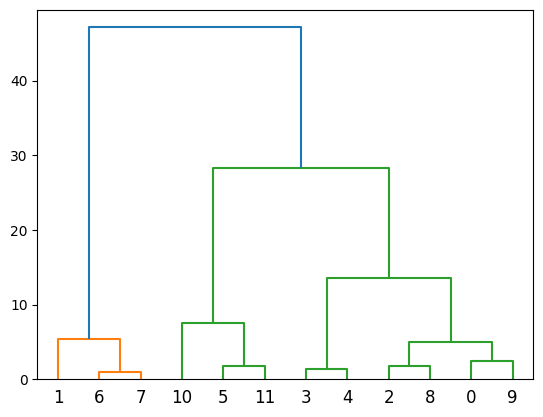

In [281]:
linkage = hierarchy.linkage(dummy_df, method = 'ward')
hierarchy.dendrogram(linkage, labels = list(dummy_df.index))
plt.show()

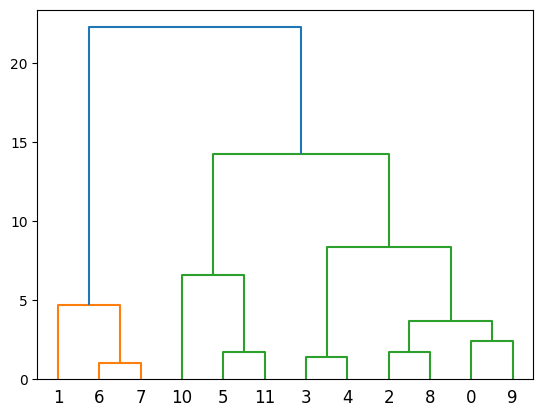

In [282]:
linkage = hierarchy.linkage(dummy_df, method = 'average')
hierarchy.dendrogram(linkage, labels = list(dummy_df.index))
plt.show()

In [283]:
hierarchy.cut_tree(linkage, n_clusters=6).T

array([[0, 1, 0, 2, 2, 3, 4, 4, 0, 0, 5, 3]])

In [20]:
dummy_df

,age,gender_f,gender_m,ethnicity_A,ethnicity_B,ethnicity_C,ethnicity_D
0,44,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000
1,18,0.000000,0.707107,0.000000,0.707107,0.000000,0.000000
2,40,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000
3,33,0.707107,0.000000,0.000000,0.000000,0.000000,0.707107
4,33,0.000000,0.707107,0.000000,0.000000,0.707107,0.000000
5,50,0.707107,0.000000,0.000000,0.707107,0.000000,0.000000
6,22,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000
7,23,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000
8,39,0.000000,0.707107,0.000000,0.707107,0.000000,0.000000
9,42,0.000000,0.707107,0.000000,0.707107,0.000000,0.000000


In [34]:
def calculate_euclidean_distances(df:pd.DataFrame)->List[ArrayLike]:
    """Used when running by attribute

    Args:
        df (pd.DataFrame): dummy encoded data

    Returns:
        List[ArrayLike]: a list of each distance matrix for each feature
    """
    dist_list = []
    for i in range(df.shape[1]):  # Iterate through the columns
        col = df.iloc[:, i].to_numpy()       # Select column i
        dist_list.append(np.abs(np.subtract.outer(col, col)))

    return dist_list

In [32]:
dist_e_list = calculate_euclidean_distances(dummy_df)

In [59]:
def dist_matrix_w(data:pd.DataFrame, weights:list=None)->ArrayLike:
    """Calculate n x n matrix with weighted averages of single-attribute distances
    between the n group members

    #TODO when calling this function in sequence, I need to have weights added for each category in a 
    Field.

    Args:
        data (pd.DataFrame): dummy encoded data
        weights (list, optional): list of weights. Defaults to None.

    Returns:
        ArrayLike:  n x n matrix with weighted averages of single-attribute distances
    """
    
    # Convert data numpy array
    data = data.values
        
    # If weights are not provided, set them to 1 for all columns
    if weights is None:
        weights = np.ones(data.shape[1])
    else:
        # Ensure weights are a NumPy array for consistency
        weights = np.asarray(weights)

    n = data.shape[0]  # number of rows
    dist_matrix = np.zeros((n, n))  # Initialize the distance matrix
    
    # Calculate the range for each column
    ranges = np.ptp(data, axis=0)  # ptp is "peak-to-peak", which computes the range (max - min)
    
    # Loop over each attribute (column)
    for attr in range(data.shape[1]):
        # Calculate the outer absolute differences
        outer_diff = np.abs(np.subtract.outer(data[:, attr], data[:, attr]))
        # Update the distance matrix with normalized values
        dist_matrix += weights[attr] * outer_diff / ranges[attr]

    # Calculate weighted average (divide by sum of weights)
    total_weight = np.sum(weights)
    dist_matrix /= total_weight
    
    return dist_matrix

In [55]:
d_w = dist_matrix_w(dummy_df, [0.1,1,1,1,1,1,1])

In [60]:
d_w.shape

(12, 12)

In [65]:
def dist_matrix_e(data:Union[ArrayLike,pd.DataFrame], weights:ArrayLike=None)->ArrayLike:
    """Calculate n x n Euclidean distance matrix, containing the pairwise Euclidean
    distances between the n group members

    Args:
        data (Union[ArrayLike,pd.DataFrame]): dummy encoded data
        weights (ArrayLike, optional): Weights for features. Defaults to None.

    Returns:
        ArrayLike: n x n Euclidean distance matrix
    """
    # Check if the input is a DataFrame; if so, convert to a NumPy array
    if isinstance(data, pd.DataFrame):
        data = data.values
        
    # If weights are not provided, set them to 1 for all columns
    if weights is None:
        weights = np.ones(data.shape[1])
    else:
        # Ensure weights are a NumPy array for consistency
        weights = np.asarray(weights)

    # Apply weights to data
    weighted_data = data * weights

    # Calculate pairwise distances using pdist and convert to a square matrix
    # The 'euclidean' metric is used because we're calculating the Euclidean distance
    dist_matrix = squareform(pdist(weighted_data, metric='euclidean'))

    return dist_matrix

In [384]:
s = np.full(n, -99.0)

In [385]:
s

array([-99., -99., -99., -99., -99., -99., -99., -99., -99., -99., -99.,
       -99.])

In [84]:
def silhouette_width(distmatrix, groups, individual="avg", usesghomo=False):
    n = len(groups)
    u = np.unique(groups)
    k = len(u)
    
    s = np.full(n, -99.0)  # Initialize silhouette widths to -99
    
    for i in range(n):
        if np.sum(groups == groups[i]) > 1:  # i is not an isolate
            a_i = 0
            b_i = np.inf
            h = []
            h_i = []
            d_i = []

            for j in u:
                g = np.where(groups == j)[0]  # All group members of group j
                g = g[g != i]  # All group members of group j, except member i
                g_i = np.concatenate((g, [i]))  # All group members of group j, and member i
                n_j = len(g)
                n_i = n_j + 1

                d_i_j = np.mean(distmatrix[g, i]) if n_j > 0 else 0  # Average distance from i to all elements of j
                d_i.append(d_i_j)

                h_j = np.mean(distmatrix[g][:, g]) if n_j > 1 else 0  # Average distance between all elements of j, except i
                h.append(h_j)

                h_i_j = np.mean(distmatrix[g_i][:, g_i]) if n_i > 1 else 0  # Average distance between all elements of j, including i
                h_i.append(h_i_j)

            dh_i = np.array(h_i) - np.array(h)  # Change in mean distances of each cluster, when i is included

            a = np.where(u == groups[i])[0][0]  # Which group does i belong to (ingroup)?
            
            d_i_inf = np.copy(d_i)
            d_i_inf[a] = np.inf  # Set the distance for the in-group to infinity
            
            b = np.argmin(d_i_inf)  # Index of the nearest out-group

            a_i = d_i[a] + usesghomo * h[b]
            b_i = d_i[b] + usesghomo * h[a]

            m = max(a_i, b_i)  # Silhouette width denominator
            
            if m != 0:
                s[i] = (b_i - a_i) / m

    s[s == -99] = 0  # Set silhouettes that are still -99 to 0

    if k == 1:
        s = np.full(n, -1)  # If there is only one cluster, set all silhouettes to -1

    return s


In [85]:
def ingroups_ind(d, d_w, d_l, data, usesghomo=False, weights=None, by_attr=False):
    n = d.shape[0]
    
    if n > 2:
        gmat = np.ones((n, n))  # Matrix that holds individual in-/outgroups by row
        outliers = s_outliers(d_w, k=1, alpha=0.9, ncol=data.shape[1] - 1)  # Detect outliers
        
        for i in range(n):
            # Sort group members by their distance to member i
            d_sorted = np.column_stack((np.arange(1, n + 1), d_w[:, i]))  # Indices and distances
            d_sorted = np.delete(d_sorted, i, axis=0)  # Remove self distance
            d_sorted = d_sorted[d_sorted[:, 1].argsort()]  # Sort by distance
            
            g = np.full(n, 2)  # Initial outgroup (2's denote outgroup members)
            g[i] = 1  # Focal group member is the first one in their ingroup
            gmat[i, :] = g  # Store in-/outgroup association in gmat
            
            # Silhouette width for outlier condition
            if by_attr:
                pass
                # s_i_max = silhouette_width_by_attr(d_l, g, usesghomo=usesghomo, weights=weights)[i]
            else:
                s_i_max = silhouette_width(d, g, usesghomo=usesghomo)[i]

            if np.isnan(outliers[i]) or not outliers[i]:  
                g[d_sorted[0, 0] - 1] = 1  # Place outgroup member nearest to i in i's ingroup
                gmat[i, :] = g  # Store in gmat
                
                # Determine initial silhouette width (2-member ingroup)
                if by_attr:
                    pass
                    # s_i_max = silhouette_width_by_attr(d_l, g, usesghomo=usesghomo, weights=weights)[i]
                else:
                    s_i_max = silhouette_width(d, groups=g, usesghomo=usesghomo)[i]

                # Add additional outgroup members to i's ingroup
                g_i = np.copy(g)
                for o in d_sorted[1:, 0].astype(int) - 1:  # Iterate over sorted distances excluding the nearest
                    g_i[o] = 1  # g_i is i's tentative in-/outgroup distribution
                    
                    if by_attr:
                        pass
                        # s_i = silhouette_width_by_attr(d_l, g_i, usesghomo=usesghomo, weights=weights)[i]
                    else:
                        s_i = silhouette_width(d, groups=g_i, individual=i, usesghomo=usesghomo)[i]

                    if s_i >= s_i_max:  # Do we have a new max?
                        g = np.copy(g_i)  # Register new max
                        gmat[i, :] = g
                        s_i_max = s_i
            
    else:
        gmat = np.zeros((1, 1))  # Return a zero matrix if there are not enough individuals

    return gmat


In [344]:
def asw_cluster(data, groups, gmax, D, individual="avg", usesghomo=False, weights=None, by_attr=False):
    maxasw = -1  # Start with minimal value for ASW
    n = len(groups)
    nv = data.shape[1]  # Number of variables (columns)

    # Allow up to gmax subgroups
    nofgroups = min(gmax, np.max(groups) + 1)

    # Initialize stop-condition
    imax = 1

    # Loop as long as target value is growing
    while imax > 0:
        # Establish stop-condition
        imax = 0

        # For each person
        for i in range(n):
            # For each subgroup to put people into
            for newgroup in range(int(nofgroups), 0, -1):
                # If group assignment changes...
                if groups[i] != newgroup:
                    # g_new is a temporary variable for the new subgroup assignment
                    g_new = np.copy(groups)

                    # Put person i into group "newgroup"
                    g_new[i] = newgroup

                    # If the new assignment produces more than two subgroups
                    if len(np.unique(g_new)) >= 2:
                        # Calculate silhouette widths
                        if by_attr:
                            pass
                            # sil = silhouette_width_by_attr(D, g_new, individual=individual, usesghomo=usesghomo, weights=weights)
                        else:
                            print(g_new)
                            sil = silhouette_width(D, g_new, individual=individual, usesghomo=usesghomo)

                        if individual == "avg":
                            # ASW as their mean value
                            asw = np.mean(sil)
                        else:
                            asw = sil[individual]

                        # If the new value for ASW reaches or exceeds the previous maximum
                        if asw > maxasw:
                            # Store new maximized ASW value (high score)
                            maxasw = asw

                            # Store person whose new group assignment caused the maximal value       
                            imax = i

                            # Store better group for person i                     
                            newgroupmax = newgroup

        # Did we find a new maximum in this round?
        if imax > 0:
            # Write new optimal partition back to grouping vector
            groups[imax] = newgroupmax

    return np.array([maxasw] + list(groups))  # Return maximum ASW and updated groups


In [76]:
dst = dist_matrix_e(dummy_df)

In [79]:
groups = [i for i in range(1,dummy_df.shape[0]+1)]

In [82]:
np.array(groups)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [83]:
ward_clustering(data = dummy_df,
                groups=np.array(groups),
                D = dst)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [114]:
def reord_groups(groups):
    g = 1
    i = 0
    gnew = np.copy(groups)  # Create a copy to avoid modifying the original
    ng = len(np.unique(groups))  # Number of unique groups
    
    while g <= ng and i < len(gnew):
        if gnew[i] > g:
            x = gnew[i]
            gnew[gnew == g] = -1  # Temporarily mark the current group
            gnew[gnew == x] = g   # Assign the current group label to the higher group
            gnew[gnew == -1] = x  # Restore the original higher group label
            g += 1
        elif gnew[i] == g:
            g += 1
        
        i += 1

    return gnew

In [248]:
def clustering_algorithm(data, D, groups, weights=None, metric='euclidean', maxgroups=6, usesghomo=False, by_attr=False, i_level=False, quiet=False):
    n = data.shape[0]  # Number of data points
    sil = np.zeros(n)
    num_sg = np.zeros(n)
    mbr = np.zeros(n)
    adjm_all = np.zeros((n, n))
    
    aswmax = -1
    subgroups = np.empty((0, n))
    
    if np.sum(D) > 0:
        if not i_level:
            # Combine Clusters using Ward's algorithm
            cl1, cl2 = 0, 1
            ward_x = np.arange(1, n + 1)

            while len(np.unique(groups)) > 1 and np.sum(D) > 0 and cl1 != cl2:
                # Initialize attribute centroids matrix
                nc = int(np.max(groups))  # Number of clusters
                centroids = np.zeros((nc, data.shape[1]))

                # Calculate cluster centroids
                for group in np.unique(groups):
                    centroids[group - 1] = np.mean(data[groups == group], axis=0)

                # Calculate cluster sizes
                cl_sizes = np.array([np.sum(groups == g) for g in np.unique(groups)])

                # Calculate distance matrix from centroids
                # if metric == 'mahal':
                #     # Placeholder for Mahalanobis distance function (S_mahal)
                #     S = S_mahal(data)  # Implement your S_mahal function
                #     dist_cent = distmatrix_m(centroids, S, weights)  # Implement your distmatrix_m function
                # elif metric == 'corr':
                #     C = C_cor(centroids) * np.diag(np.ones(centroids.shape[1]))
                #     centroids = centroids @ C
                #     dist_cent = distmatrix_e(centroids, weights)  # Implement your distmatrix_e function
                # elif metric == 'gower':
                #     dist_cent = distmatrix_g(centroids)  # Implement your distmatrix_g function
                # else:
                dist_cent = dist_matrix_e(centroids, weights)

                cl_mat = np.zeros((len(cl_sizes), len(cl_sizes)))
                for i in range(len(cl_sizes)):
                    for j in range(len(cl_sizes)):
                        cl_mat[i, j] = cl_sizes[i] + cl_sizes[j]

                dist_cent = dist_cent * (np.outer(cl_sizes, cl_sizes) / cl_mat)

                # Replace NaN with max distance + 1
                dist_cent[np.isnan(dist_cent)] = np.max(dist_cent) + 1

                # Replace diagonal elements with max distance + 1
                np.fill_diagonal(dist_cent, np.max(dist_cent) + 1)

                # Find minimal distance
                dcmin = np.unravel_index(np.argmin(dist_cent, axis=None), dist_cent.shape)

                # Find centroids to combine
                cl1 = dcmin[0] + 1  # Adjust for 1-based indexing
                cl2 = dcmin[1] + 1  # Adjust for 1-based indexing

                # Combine clusters
                groups[groups == cl2] = cl1
                groups = reord_groups(groups)
                ward_x = np.column_stack((groups, ward_x))

            # Combine clusters with average linkage method
            groups = np.arange(1, n + 1)
            cl1, cl2 = 0, 1
            average_link = np.copy(groups)
            while len(np.unique(groups)) > 1 and np.sum(D) > 0 and cl1 != cl2:
                min_avg_link = np.max(D)
                for i in np.unique(groups):
                    for j in np.unique(groups):
                        if i != j:
                            d = np.mean(D[groups == i][:, groups == j])
                            if d <= min_avg_link:
                                min_avg_link = d
                                cl1 = i
                                cl2 = j
                # Combine clusters
                groups[groups == cl2] = cl1
                groups = reord_groups(groups)
                average_link = np.column_stack((groups, average_link))

            # Now call clustering with ASW maximizing
            n_w = min(maxgroups, ward_x.shape[1], average_link.shape[1])

            # return average_link,ward_x,n_w
            # a_l = pd.DataFrame(average_link[:, 1:n_w])[
            #     pd.Series(np.abs(average_link[:, 1:n_w] - ward_x[:, 1:n_w])).sum(axis=0) > 0
            # ]
            
            filtered_columns = np.abs(average_link[:,1:n_w] - ward_x[:,1:n_w]).sum(axis=0)>0
            a_l = pd.DataFrame(average_link[:,1:n_w][:,filtered_columns])


            m = np.column_stack((np.ones(n), ward_x[:, 1:n_w], a_l))

            a_l_names = np.full(a_l.shape[1], "average_linkage") if a_l.shape[1] > 0 else []

            methods = ["constant"] + ["ward"] * (n_w - 1) + a_l_names.tolist()


            asw = np.array([])
            sil = np.zeros(n)
            num_sg = np.zeros(n)
            mbr = np.zeros(n)

            aswmax = -1
            subgroups = np.empty((0, n))

            i_steps = ["avg"]
            if i_level:
                i_steps = np.arange(1, n + 1)

            adjm_all = np.zeros((n, n))
            asw_all = np.zeros(n_w)

            for individual in i_steps:
                # if i_steps == "avg":
                #     individual = "avg"
                aswmax = -1
                groupmax = np.array([1])
                print(m.shape[1]+4)
                for i in range(m.shape[1]):
                    print(i)
                    try:
                        groups = m[:, i]
                    except:
                        return m,i

                    if n > 1:
                        res_asw = asw_cluster(data, groups, maxgroups, D, individual, usesghomo=usesghomo, weights=weights, by_attr=by_attr)
                    else:
                        res_asw = np.array([-1, 1])

                    g = reord_groups(res_asw[1:])
                    try:
                        asw = np.append(asw, [round(res_asw[0], 8)])
                    except: return asw, res_asw, i

                    groups_x = g
                    if asw[i] >= aswmax:
                        print(aswmax)
                        if asw[i] == aswmax:
                            if len(np.unique(g)) < len(np.unique(groupmax)):
                                aswmax = asw[i]
                                groupmax = g
                                ng = len(np.unique(groupmax))
                                max_i = i
                                max_method = methods[i]
                            else:
                                if len(np.unique(g)) == len(np.unique(groupmax)):
                                    # return max_method, methods, i
                                    try:
                                        max_method = np.unique([max_method[0], methods[i]])
                                    except:
                                        return max_method, methods, i
                        else:
                            aswmax = asw[i]
                            groupmax = g
                            ng = len(np.unique(groupmax))
                            max_i = i
                            max_method = methods[i]
                    method = methods[i]
                    print(methods)
                    print('### method {}'.format(method))
                    if not quiet:
                        print(f"Attempt {i} Method: {method} Asw: {asw[i]} Groups: {m[:, i]} --> {g}")

                if not quiet:
                    print(f"Groups: {groupmax} ASW: {aswmax} #groups: {ng} method: {max_method}")

                if individual == "avg":
                    if by_attr:
                        pass
                        # sil = silhouette_width_by_attr(D, groupmax, individual=individual, usesghomo=usesghomo, weights=weights)
                    else:
                        sil = silhouette_width(D, groupmax, individual=individual, usesghomo=usesghomo)

                    num_sg = len(np.unique(groupmax))
                    mbr = individual
                    subgroups = np.vstack([subgroups, groupmax])
                    adjm_all = np.nan
                else:
                    sil[individual] = aswmax
                    num_sg[individual] = len(np.unique(groupmax))
                    mbr[individual] = individual
                    adjm_individual = (groupmax[:, None] @ groupmax[None, :] == groupmax[:, None]**2) * 1
                    subgroups = np.vstack([subgroups, groupmax])
                    adjm_all += adjm_individual

                if i_steps == "avg":
                    break
            adjm_all /= n

        else:  # Individual mode
            gmat = ingroups_ind(D, D, D, data, usesghomo=usesghomo, weights=weights, by_attr=by_attr)
            sil = []
            if n > 2:
                for focal in range(n):
                    groupmax = gmat[focal, :]
                    # sil_focal = silhouette_width_by_attr(D, groupmax, usesghomo=usesghomo, weights=weights)[focal] if by_attr else silhouette_width(D, groupmax, usesghomo=usesghomo)[focal]
                    sil_focal = silhouette_width(D, groupmax, usesghomo=usesghomo)[focal]
                    sil.append(sil_focal)

                    num_sg[focal] = len(np.unique(groupmax))
                    mbr[focal] = focal + 1
                    adjm_individual = (groupmax[:, None] @ groupmax[None, :] == groupmax[:, None]**2) * 1
                    adjm_all += adjm_individual

                adjm_all /= n
                aswmax = 0
                subgroups = gmat
            else:
                aswmax = 0
                sil = np.zeros(n)
                subgroups = np.ones(n)
                num_sg = 1
                mbr = 1
                adjm_all = np.zeros((n, n))

    else:  # All persons are identical in all attributes
        aswmax = 0
        sil = np.zeros(n)
        subgroups = np.ones(n) if i_level else np.array([1] * n)
        num_sg = 1
        mbr = 1
        adjm_all = np.zeros((n, n))

    return {
        "asw": np.mean(sil),
        "sil": sil,
        "groups": subgroups,
        "num_sg": num_sg,
        "mbr": mbr,
        "adjm": adjm_all
    }



In [225]:
np.array(groups)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [345]:
clustering_algorithm(data=dummy_df,D=dst,groups=np.array(groups),maxgroups=6)

11
0
[2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
[2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.]
[1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1.]
[1. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.]
[1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.]
[1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1.]
[1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1.]
[1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.]
[1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
[2. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.]
[1. 2. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1.]
[1. 2. 

{'asw': np.float64(0.6527976437863343),
 'sil': array([0.55721486, 0.68641691, 0.61622784, 0.83058886, 0.83048142,
        0.49640099, 0.76316114, 0.69248919, 0.45956506, 0.71011566,
        0.58410879, 0.606801  ]),
 'groups': array([[1., 2., 1., 3., 3., 4., 2., 2., 1., 1., 4., 4.]]),
 'num_sg': 4,
 'mbr': 'avg',
 'adjm': nan}

In [249]:
clustering_algorithm(data=dummy_df,D=dst,groups=np.array(groups),maxgroups=6)

11
0
-1
['constant', 'ward', 'ward', 'ward', 'ward', 'ward', 'average_linkage']
### method constant
Attempt 0 Method: constant Asw: 0.58063743 Groups: [1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1.] --> [1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1.]
1
0.58063743
['constant', 'ward', 'ward', 'ward', 'ward', 'ward', 'average_linkage']
### method ward
Attempt 1 Method: ward Asw: 0.58063743 Groups: [1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1.] --> [1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1.]
2
['constant', 'ward', 'ward', 'ward', 'ward', 'ward', 'average_linkage']
### method ward
Attempt 2 Method: ward Asw: 0.53939847 Groups: [1. 2. 1. 1. 1. 3. 2. 2. 1. 1. 3. 3.] --> [1. 2. 1. 1. 1. 3. 2. 2. 1. 1. 3. 3.]
3
0.58063743
['constant', 'ward', 'ward', 'ward', 'ward', 'ward', 'average_linkage']
### method ward
Attempt 3 Method: ward Asw: 0.65279764 Groups: [1. 2. 1. 3. 3. 4. 2. 2. 1. 1. 4. 4.] --> [1. 2. 1. 3. 3. 4. 2. 2. 1. 1. 4. 4.]
4
0.65279764
['constant', 'ward', 'ward', 'ward', 'ward', 'ward', 'average_linkage']
### method 

{'asw': np.float64(0.6527976437863343),
 'sil': array([0.55721486, 0.68641691, 0.61622784, 0.83058886, 0.83048142,
        0.49640099, 0.76316114, 0.69248919, 0.45956506, 0.71011566,
        0.58410879, 0.606801  ]),
 'groups': array([[1., 2., 1., 3., 3., 4., 2., 2., 1., 1., 4., 4.]]),
 'num_sg': 4,
 'mbr': 'avg',
 'adjm': nan}

In [247]:
m

array([[1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 5.],
       [1., 1., 1., 1., 1., 3., 1.],
       [1., 1., 1., 3., 3., 4., 3.],
       [1., 1., 1., 3., 3., 4., 3.],
       [1., 1., 3., 4., 4., 5., 4.],
       [2., 2., 2., 2., 2., 2., 5.],
       [2., 2., 2., 2., 2., 2., 5.],
       [1., 1., 1., 1., 1., 3., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 3., 4., 4., 6., 4.],
       [1., 1., 3., 4., 4., 5., 4.]])

In [246]:
m[:, i]

IndexError: index 7 is out of bounds for axis 1 with size 7

In [235]:
max_method, methods, i

(array(['ward'], dtype='<U4'),
 ['constant', 'ward', 'ward', 'ward', 'ward', 'ward', 'average_linkage'],
 6)

In [241]:
np.unique([max_method[0], methods[i]])

array(['average_linkage', 'ward'], dtype='<U15')

In [240]:
[max_method[0], methods[i]]

[np.str_('ward'), 'average_linkage']

In [238]:
methods[i]

'average_linkage'

In [185]:
methods[i]

'ward'

In [186]:
np.unique([max_method, methods[i]])

array(['constant', 'ward'], dtype='<U8')

In [181]:
np.concatenate(max_method, methods[i])

TypeError: 'str' object cannot be interpreted as an integer

In [109]:
n_w

10

In [162]:
filtered_columns = np.abs(average_link[:,1:n_w] - ward_x[:,1:n_w]).sum(axis=0)>0

In [165]:
average_link[:,1:n_w][:,filtered_columns]

array([[1, 1],
       [2, 2],
       [1, 3],
       [3, 4],
       [3, 4],
       [4, 5],
       [5, 6],
       [5, 6],
       [1, 7],
       [1, 8],
       [6, 9],
       [4, 5]])

In [123]:
average_link_df = pd.DataFrame(average_link)
ward_x_df = pd.DataFrame(ward_x)

# Calculate the absolute differences
abs_diff = np.abs(average_link_df.iloc[:, 1:].values - ward_x_df.iloc[:, 1:].values)

# Sum the absolute differences for each column
column_sums = abs_diff.sum(axis=0)

# Filter columns where the sum of absolute differences is greater than 0
filtered_columns = column_sums > 0

# Create the final DataFrame with only the relevant columns
result_df = average_link_df.iloc[:, 1:][filtered_columns]


ValueError: Item wrong length 11 instead of 12.

In [124]:
# Sample data for average_link and ward_x
average_link = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3],
    [1, 1, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4],
    [1, 1, 1, 3, 3, 3, 4, 4, 4, 4, 4, 5],
    [1, 1, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6],
    [1, 2, 2, 2, 2, 5, 6, 6, 6, 6, 7, 7],
    [1, 2, 2, 2, 2, 5, 6, 6, 6, 6, 7, 8],
    [1, 1, 1, 1, 1, 1, 3, 3, 7, 7, 8, 9],
    [1, 1, 1, 1, 1, 1, 1, 7, 8, 8, 9, 10],
    [1, 1, 3, 4, 5, 6, 7, 8, 9, 9, 10, 11],
    [1, 1, 3, 4, 4, 4, 5, 5, 5, 10, 11, 12]
])

ward_x = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3],
    [1, 1, 1, 3, 3, 4, 4, 4, 4, 4, 4, 4],
    [1, 1, 1, 3, 3, 4, 4, 4, 4, 4, 5, 5],
    [1, 1, 3, 4, 4, 5, 5, 5, 5, 5, 6, 6],
    [1, 2, 2, 2, 2, 2, 6, 6, 6, 6, 7, 7],
    [1, 2, 2, 2, 2, 2, 6, 6, 6, 6, 7, 8],
    [1, 1, 1, 1, 1, 3, 3, 3, 3, 7, 8, 9],
    [1, 1, 1, 1, 1, 1, 1, 7, 7, 8, 9, 10],
    [1, 1, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11],
    [1, 1, 3, 4, 4, 5, 5, 5, 9, 10, 11, 12]
])

# Convert to DataFrame for easier manipulation
average_link_df = pd.DataFrame(average_link)
ward_x_df = pd.DataFrame(ward_x)

# Calculate the absolute differences
abs_diff = np.abs(average_link_df.iloc[:, 1:].values - ward_x_df.iloc[:, 1:].values)

# Sum the absolute differences for each column (excluding the first column)
column_sums = abs_diff.sum(axis=0)

# Filter columns where the sum of absolute differences is greater than 0
filtered_columns = column_sums > 0

# Create the final DataFrame with only the relevant columns
result_df = average_link_df.iloc[:, 1:][filtered_columns]

# Display the result
print(result_df)

ValueError: Item wrong length 11 instead of 12.

In [151]:
len(filtered_columns)

11

In [154]:
test = average_link_df.iloc[:, 1:].copy()

In [157]:
test[filtered_columns]

ValueError: Item wrong length 11 instead of 12.

In [158]:
average_link_df.iloc[:, 1:].loc[:, filtered_columns]

,5,8,10
0,1,1,1
1,2,2,2
2,1,3,3
3,3,4,4
4,3,4,4
5,4,5,6
6,5,6,7
7,5,6,7
8,1,7,8
9,1,8,9


In [143]:
filtered_columns

array([False, False, False, False,  True, False, False,  True, False,
        True, False])

In [129]:
np.abs(average_link[:,1:n_w] - ward_x[:,1:n_w])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 4, 0]])

In [141]:
average_link[:,1:n_w]

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 1,  1,  1,  1,  1,  3,  3,  3,  3],
       [ 1,  1,  3,  3,  3,  4,  4,  4,  4],
       [ 1,  1,  3,  3,  3,  4,  4,  4,  4],
       [ 1,  3,  4,  4,  4,  5,  5,  5,  5],
       [ 2,  2,  2,  2,  5,  6,  6,  6,  6],
       [ 2,  2,  2,  2,  5,  6,  6,  6,  6],
       [ 1,  1,  1,  1,  1,  3,  3,  7,  7],
       [ 1,  1,  1,  1,  1,  1,  7,  8,  8],
       [ 1,  3,  4,  5,  6,  7,  8,  9,  9],
       [ 1,  3,  4,  4,  4,  5,  5,  5, 10]])

In [142]:
ward_x[:,1:n_w]

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 1,  1,  1,  1,  3,  3,  3,  3,  3],
       [ 1,  1,  3,  3,  4,  4,  4,  4,  4],
       [ 1,  1,  3,  3,  4,  4,  4,  4,  4],
       [ 1,  3,  4,  4,  5,  5,  5,  5,  5],
       [ 2,  2,  2,  2,  2,  6,  6,  6,  6],
       [ 2,  2,  2,  2,  2,  6,  6,  6,  6],
       [ 1,  1,  1,  1,  3,  3,  3,  3,  7],
       [ 1,  1,  1,  1,  1,  1,  7,  7,  8],
       [ 1,  3,  4,  5,  6,  7,  8,  8,  9],
       [ 1,  3,  4,  4,  5,  5,  5,  9, 10]])

In [128]:
average_link[1:,1:n_w]

array([[ 2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 1,  1,  1,  1,  1,  3,  3,  3,  3],
       [ 1,  1,  3,  3,  3,  4,  4,  4,  4],
       [ 1,  1,  3,  3,  3,  4,  4,  4,  4],
       [ 1,  3,  4,  4,  4,  5,  5,  5,  5],
       [ 2,  2,  2,  2,  5,  6,  6,  6,  6],
       [ 2,  2,  2,  2,  5,  6,  6,  6,  6],
       [ 1,  1,  1,  1,  1,  3,  3,  7,  7],
       [ 1,  1,  1,  1,  1,  1,  7,  8,  8],
       [ 1,  3,  4,  5,  6,  7,  8,  9,  9],
       [ 1,  3,  4,  4,  4,  5,  5,  5, 10]])

In [ ]:
 groups groups groups groups groups groups groups groups groups groups groups   
 [1,]      1      1      1      1      1      1      1      1      1      1      1  1
 [2,]      1      2      2      2      2      2      2      2      2      2      2  2
 [3,]      1      1      1      1      1      1      3      3      3      3      3  3
 [4,]      1      1      1      3      3      3      4      4      4      4      4  4
 [5,]      1      1      1      3      3      3      4      4      4      4      5  5
 [6,]      1      1      3      4      4      4      5      5      5      5      6  6
 [7,]      1      2      2      2      2      5      6      6      6      6      7  7
 [8,]      1      2      2      2      2      5      6      6      6      6      7  8
 [9,]      1      1      1      1      1      1      3      3      7      7      8  9
[10,]      1      1      1      1      1      1      1      7      8      8      9 10
[11,]      1      1      3      4      5      6      7      8      9      9     10 11
[12,]      1      1      3      4      4      4      5      5      5     10     11 12

In [ ]:
groups groups groups groups groups groups groups groups groups
 [1,]      1      1      1      1      1      1      1      1      1
 [2,]      2      2      2      2      2      2      2      2      2
 [3,]      1      1      1      1      1      3      3      3      3
 [4,]      1      1      3      3      3      4      4      4      4
 [5,]      1      1      3      3      3      4      4      4      4
 [6,]      1      3      4      4      4      5      5      5      5
 [7,]      2      2      2      2      5      6      6      6      6
 [8,]      2      2      2      2      5      6      6      6      6
 [9,]      1      1      1      1      1      3      3      7      7
[10,]      1      1      1      1      1      1      7      8      8
[11,]      1      3      4      5      6      7      8      9      9
[12,]      1      3      4      4      4      5      5      5     10

In [110]:
np.abs(average_link[:, 1:n_w] - ward_x[:, 1:n_w])

array([[1, 1, 2, 2, 3, 4, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 0, 0, 0],
       [1, 1, 2, 2, 1, 1, 2, 0, 0],
       [1, 1, 2, 2, 2, 2, 1, 0, 0],
       [1, 1, 2, 2, 2, 2, 1, 0, 0],
       [1, 0, 0, 1, 1, 2, 3, 4, 0],
       [1, 1, 0, 0, 1, 3, 2, 1, 0],
       [1, 1, 0, 0, 1, 3, 2, 1, 0],
       [1, 1, 2, 2, 1, 1, 2, 3, 0],
       [1, 1, 2, 2, 3, 4, 1, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 2, 3, 0, 0]])

In [105]:
pd.Series(np.abs(average_link[:, 1:n_w] - ward_x[:, 1:n_w]).sum(axis=0) > 0).sum(axis=0)>0
pd.Series(np.abs(average_link[:, 1:n_w] - ward_x[:, 1:n_w]).sum(axis=0) > 0

np.True_

In [107]:
pd.Series(np.abs(average_link[:, 1:n_w] - ward_x[:, 1:n_w]).sum(axis=0)) > 0

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8    False
dtype: bool

In [108]:
a_l = pd.DataFrame(average_link[:, 1:n_w])[
    pd.Series(np.abs(average_link[:, 1:n_w] - ward_x[:, 1:n_w]).sum(axis=0)) > 0
]

/var/folders/9l/1xgvrcy5545b3kwy8sbpb_7h0000gn/T/ipykernel_69756/38066042.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a_l = pd.DataFrame(average_link[:, 1:n_w])[


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [100]:
pd.Series(np.abs(average_link_df.iloc[:, 1:n_w].values - ward_x_df.iloc[:, 1:n_w].values)).sum(axis=0) > 0

NameError: name 'average_link_df' is not defined

In [99]:
pd.Series(np.abs(average_link[:, 1:n_w] - ward_x[:, 1:n_w])).sum(axis=0) > 0

ValueError: Data must be 1-dimensional, got ndarray of shape (12, 9) instead